In [ ]:
# установка последнего lightautoml
# !pip install -q git+https://github.com/sb-ai-lab/LightAutoML.git

In [ ]:
import os
if 'drive' not in os.listdir():
    from google.colab import drive
    drive.mount('/content/drive')

path_to_folder = '/content/drive/MyDrive/psb_hack'

In [ ]:
# standard libraries
import sys
import os
import json
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# ds libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
# lama
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
# save/load model
import joblib
import gc
import yaml
# свои функции по оценке метрик
path_to_model_utils = '/content/drive/MyDrive/psb_hack'
sys.path.append(os.path.join(path_to_model_utils,'model_utils'))
from model_estimation import *

# Создание конфига

In [ ]:
VERSION_DATA = 1
config_dataset = dict(
    version = VERSION_DATA,
    id_col = '№ брони',
    target_col = 'Дата отмены',
    nan_constant_rates = {'max_nan_rate' : 0.95, 'max_constant_rate' : 0.95},
    train_file = os.path.join(path_to_folder,'data','train.xlsx'),
    test_file = os.path.join(path_to_folder,'data','test.xlsx'),
    random_state = 42,
    val_size = 0.2,
)
VERSION_MODEL = 1
config_model = dict(
                    # group_filter = None,#{'column' : 'product', 'value' : product_dict[product]},
                    n_threads = 1,
                    n_folds = 5,
                    random_state = 42,
                    task = dict(name='binary',metric='auc', loss='logloss',greater_is_better=True),
                    general_params = {'use_algos': [['cb','cb_tuned','lgb','lgb_tuned',
                                                     'rf','linear_l2',
                                                     'xgb', 'xgb_tuned']],
                                      'weighted_blender_max_nonzero_coef' : 0.05,},
                    advanced_roles = False,
                    roles = {'target': 'Дата отмены',
                             'category': ['Способ оплаты', 'Источник', 'Категория номера'],
                             'drop' : ['Статус брони']},

                    model_name = f'psb_hack_lama_v{VERSION_MODEL}',
    )


# нужно корректировать roles чтобы в drop докидывать config_dataset['target_table_columns']
config_model['roles']['drop'] = sorted(set([config_dataset['id_col']] + config_model['roles'].get('drop',[])))
config_model['roles']['category'] += ['booking_month','booking_day','booking_dayofweek','booking_season',
                                      'checkin_month','checkin_season','checkin_day','checkin_dayofweek',
                                      'checkout_month','checkout_day','checkout_dayofweek'
                                      ]

model_file =  os.path.join(path_to_folder,'models',config_model['model_name'] + '.pkl')

In [ ]:
def calc_mean_target_features(df, output_file_name, group_columns, window_sizes, date_col_name, min_objects_in_window=1, target_col_name="target"):
    """
    Окно для каждой даты-времени смотрит назад на window_size дней
    Для каждой даты мы возьмем последнее значение и сохраним
    Дата выкидывается, если в ее окне оказалось меньше min_objects_in_window наблюдений
    :param group_columns: колонки, по которым сгруппировать
    :param target_col_name: имя колонки таргета
    :param date_col_name: имя колонки даты
    :param output_file_name: имя выходного файла

    Статистики мапятся в выходной файл словарем в формате
    Группировочная колонка: статистика: размер окна (например, 5D): дата: значение
    value = dict[col][stat][window][str(date)]
    """
    df = df.copy()
    split_string = "-"

    df[date_col_name] = pd.to_datetime(df[date_col_name])
    df = df.set_index(date_col_name).sort_index()
    added_features_names = []

    for col_name in group_columns:
        for window_size in window_sizes:
            feature_name = split_string + f"{window_size}D" + split_string + col_name

            avg_feature_name = "avg" + feature_name
            added_features_names.append(avg_feature_name)
            df[avg_feature_name] = df[target_col_name].rolling(window=f"{window_size}D", min_periods=min_objects_in_window).mean()

            var_feature_name = "var" + feature_name
            added_features_names.append(var_feature_name)
            df[var_feature_name] = df[target_col_name].rolling(window=f"{window_size}D", min_periods=min_objects_in_window).std()

    df = df.reset_index(drop=False).drop_duplicates(subset=[date_col_name], keep='last').set_index(date_col_name)
    calculated_stats = {}

    for feature_name in added_features_names:
        stat, window, col_name = feature_name.split(split_string)
        for date in tqdm(df.index, desc=f"processing {col_name}_{window}_{stat}"):
            if col_name not in calculated_stats:
                calculated_stats[col_name] = {}
            if stat not in calculated_stats[col_name]:
                calculated_stats[col_name][stat] = {}
            if window not in calculated_stats[col_name][stat]:
                calculated_stats[col_name][stat][window] = {}
            calculated_stats[col_name][stat][window][date] = df.loc[date, feature_name]

    with open(output_file_name, "wb") as fp:
        joblib.dump(calculated_stats , fp)

def add_mean_target_features(df, file_name, group_columns, window_sizes, date_col_name, target_col_name="target"):
    #     value = dict[col][stat][window][str(date)]
    df = df.copy()
    # df[date_col_name] = df[date_col_name].astype("str")
    with open(file_name, "rb") as json_file:
        stats = joblib.load(json_file)
        for col in group_columns:
            if col in stats:
                for window_size in window_sizes:
                    window_size = f"{window_size}D"
                    if window_size in stats[col]["avg"]:
                        col_name = f"avg_{target_col_name}_by_" + col + "_" + window_size
                        dates_avg = pd.Series(stats[col]["avg"][window_size])
                        dates_avg.name = col_name
                        df = pd.merge(df, dates_avg, left_on=date_col_name, right_index=True, how="left")

                    if window_size in stats[col]["var"]:
                        col_name = f"var_{target_col_name}_by_" + col + "_" + window_size
                        dates_var = pd.Series(stats[col]["var"][window_size])
                        dates_var.name = col_name
                        df = pd.merge(df, dates_var, left_on=date_col_name, right_index=True, how="left")
        return df

In [ ]:
def date_features(df):
    '''
    Признаки сгенерированные из временных полей:
    - Дата бронирования
    - Заезд
    - Выезд
    Суть признаков:
    - посчитать месяц, квартал, сезон в этих датах
    - выявить разницу в днях между бронированием и выявить флаги бизнесовые на основе разниц между датами
    '''
    # вспомогательные словари
    datecol2eng_map = {'Дата бронирования':'booking','Заезд':'checkin','Выезд':'checkout'}
    season_map_dict = {1 : 'winter', 2 : 'winter', 12: 'winter',
                        3: 'spring', 4: 'spring', 5: 'spring',
                        6: 'summer', 7: 'summer', 8: 'summer',
                        9: 'autumn', 10: 'autumn',11: 'autumn'}
    # Конвертация дат в формат datetime
    df['Дата бронирования'] = pd.to_datetime(df['Дата бронирования'])
    df['Заезд'] = pd.to_datetime(df['Заезд'])
    df['Выезд'] = pd.to_datetime(df['Выезд'])
    # посчитать месяц, квартал, сезон в этих датах
    for date_col in ['Дата бронирования','Заезд','Выезд']:
        # Создание новых признаков
        eng_name = datecol2eng_map[date_col]
        df[f'{eng_name}_year'] = df[date_col].dt.year
        df[f'{eng_name}_month'] = df[date_col].dt.month
        df[f'{eng_name}_day'] = df[date_col].dt.day
        df[f'{eng_name}_dayofweek'] = df[date_col].dt.dayofweek
        df[f'{eng_name}_weekofyear'] = df[date_col].dt.isocalendar().week
        df[f'{eng_name}_is_weekend'] = df[f'{eng_name}_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
        df[f'{eng_name}_quarter'] = df[date_col].dt.quarter
        df[f'{eng_name}_quarter'] = df[date_col].dt.quarter
        df[f'{eng_name}_season'] = df[f'{eng_name}_month'].map(lambda x: season_map_dict[x])
        df[f'{eng_name}_is_month_start'] = df[date_col].dt.is_month_start.astype(int)
        df[f'{eng_name}_is_month_end'] = df[date_col].dt.is_month_end.astype(int)
        df[f'{eng_name}_is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
        df[f'{eng_name}_is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
        df[f'{eng_name}_is_year_start'] = df[date_col].dt.is_year_start.astype(int)
        df[f'{eng_name}_is_year_end'] = df[date_col].dt.is_year_end.astype(int)
        df[f'{eng_name}_hour'] = df[date_col].dt.hour
        # Синус и косинус дня недели (для учета цикличности)
        df[f'{eng_name}_dayofweek_sin'] = np.sin(2 * np.pi * df[f'{eng_name}_dayofweek'] / 7)
        df[f'{eng_name}_dayofweek_cos'] = np.cos(2 * np.pi * df[f'{eng_name}_dayofweek'] / 7)

        # Синус и косинус месяца
        df[f'{eng_name}_month_sin'] = np.sin(2 * np.pi * df[f'{eng_name}_month'] / 12)
        df[f'{eng_name}_month_cos'] = np.cos(2 * np.pi * df[f'{eng_name}_month'] / 12)
        # sin cos hour
        df[f'{eng_name}_hour_sin'] = np.sin(2 * np.pi * df[f'{eng_name}_hour'] / 24)
        df[f'{eng_name}_hour_cos'] = np.cos(2 * np.pi * df[f'{eng_name}_hour'] / 24)

    # разница между датами
    df['booking_to_checkin_days'] = (df['Заезд'] - df['Дата бронирования']).dt.days
    df['booking_to_checkin_months'] = df['booking_to_checkin_days'] // 30
    df['checkin_to_checkout_days'] = (df['Выезд'] - df['Заезд']).dt.days

    # Флаги раннего/позднего бронирования
    df['is_last_week_booking'] = df['booking_to_checkin_days'].apply(lambda x: 1 if x <= 7 else 0)
    df['is_early_booking'] = df['booking_to_checkin_days'].apply(lambda x: 1 if x >= 30 else 0)

    df['Дата бронирования'] = pd.to_datetime(df['Дата бронирования'].dt.date)
    df['Заезд'] = pd.to_datetime(df['Заезд'].dt.date)
    df['Выезд'] = pd.to_datetime(df['Выезд'].dt.date)

    drop_columns = ['booking_to_checkin_days']

    return df.drop(columns=drop_columns)

In [ ]:
def category_room_features(df):
    '''
    Признаки сгенерированные из 'Категория номера':
    - можно вытащить количество типов номеров в заказе: сколько было забронировано Студий, Стандартов, Люксов, Коттеджей
    - сколько спален в броне всего
    - флаг номера для малоактивных гостей
    - флаг отдельного входа
    - флаг брони разных номеров
    '''
    splitter = re.compile("([0-9]+)\. ")
      # Создание признаков из 'Категория номера'
    df['Категория номера'] = df['Категория номера'].astype(str)
    # распарсить признак Категория номера
    df['rooms'] = df['Категория номера'].map(lambda x: list(filter(lambda y: not y.isdigit() and y != '', re.split(splitter,x.replace('\n',' ')))))
    df['rooms'] = df['rooms'].map(lambda x: list(map(str.strip,x)))
    # количество типов номеров в заказе: сколько было забронировано Студий, Стандартов, Люксов, Коттеджей
    df['has_apart'] = df['rooms'].map(lambda x: sum(map(lambda y: 'Апарт' in y,x)))
    df['has_luxe'] = df['rooms'].map(lambda x: sum(map(lambda y: 'Люкс' in y,x)))
    df['has_standard'] = df['rooms'].map(lambda x: sum(map(lambda y: 'Стандарт' in y,x)))
    df['has_studio'] = df['rooms'].map(lambda x: sum(map(lambda y: 'Студия' in y,x)))
    df['has_cottage'] = df['rooms'].map(lambda x: sum(map(lambda y: 'Коттедж' in y,x)))
    # сколько спален
    df['count_bedrooms'] = df['rooms'].map(lambda x: sum(map(lambda y: int(re.findall(r'\d+',y)[0]) if re.findall(r'\d+',y) else 1,x)))
    # флаги
    df['has_low_active'] = df['rooms'].map(lambda x: int(sum(map(lambda y: 'маломобильных' in y,x)) > 0))
    df['has_own_entarance'] = df['rooms'].map(lambda x: int(sum(map(lambda y: 'отдельным входом' in y,x)) > 0))
    df['is_all_rooms_same'] = df['rooms'].map(lambda x: int(len(set(x)) == 1))

    drop_columns = ['rooms']

    return df.drop(columns=drop_columns)

In [ ]:
def cost_prepayment_features(df):
    '''
    Признаки сгенерированные из Стоимость, Внесена предоплата c учетом Ночей, Гостей, номеров:
    - Стоимость за ночь
    - Средняя стоимость номера из номеров
    - Средняя стоимость номера на человека
    - Отношение предоплаты ко стоимости
    - Предоплата на гостя
    - Доля остатка внесения
    - Флаги наличия предоплаты
    '''
    # Стоимость за ночь
    df['cost_per_night'] = df['Стоимость'] / df['Ночей']
    df['cost_per_room'] = df['cost_per_night'] / df['Номеров']
    df['cost_per_guest'] = df['cost_per_room'] / df['Гостей']
    # Отношение предоплаты ко стоимости
    df['prepayment_ratio'] = df['Внесена предоплата'] / df['Стоимость']
    df['remaining_payment_ratio'] = (df['Стоимость'] - df['Внесена предоплата']) / df['Стоимость']
    # Предоплата на гостя
    df['prepayment_per_guest'] = df['Внесена предоплата'] / df['Гостей']
    # Флаги наличия предоплаты
    df['has_prepayment'] = df['Внесена предоплата'].apply(lambda x: 1 if x > 0 else 0)
    # Средняя стоимость на человека
    df['avg_cost_per_person'] = df['Стоимость'] / df['Гостей']
    df['avg_remaining_payment_per_person'] = (df['Стоимость'] - df['Внесена предоплата']) / df['Гостей']

    return df

def log_prepayment_features(df):
    '''Логарифмы взамен оригинала'''
    df['log_total_cost'] = np.log1p(df['Стоимость'])
    df['log_prepayment'] = np.log1p(df['Внесена предоплата'])
    df['log_cost_per_night'] = np.log1p(df['cost_per_night'])
    df['log_cost_per_room'] = np.log1p(df['cost_per_room'])
    df['log_cost_per_guest'] = np.log1p(df['cost_per_guest'])
    df['log_prepayment_per_guest'] = np.log1p(df['prepayment_per_guest'])
    df['log_avg_cost_per_person'] = np.log1p(df['avg_cost_per_person'])
    df['log_avg_remaining_payment_per_person'] = np.log1p(df['avg_remaining_payment_per_person'])

    drop_columns = ['Стоимость','Внесена предоплата','cost_per_night','cost_per_room',
                    'cost_per_guest','prepayment_per_guest','avg_cost_per_person',
                    'avg_remaining_payment_per_person']

    return df.drop(columns=drop_columns)

In [ ]:
def guest_features(df):
    '''
    Признаки сгенерированные по 'Гостей' и 'Ночей':
    - флаги размера группы
    - флаг длительности прибывания
    - флаг сути отдыха
    '''
    # флаги размера группы
    df['is_family'] = df['Гостей'].map(lambda x: 1 if x > 1 and x <= 4 else 0)
    df['is_group'] = df['Гостей'].map(lambda x: 1 if x > 4 else 0)
    # флаг сути отдыха
    df['is_weekend'] = (df['checkin_is_weekend'] & (df['checkin_to_checkout_days'] < 3)).astype(int)
    df['is_business_trip'] = ((df['checkin_is_weekend'] == 0) & (df['checkout_is_weekend'] == 0) & (df['checkin_to_checkout_days'] < 7))
    # флаг длительности прибывания
    df['is_long_trip'] = (df['checkin_to_checkout_days'] >= 7).astype(int)
    # взаимодействие между признаками
    df['rooms_times_nights'] = df['Номеров'] * df['Ночей']
    df['guests_per_room'] = df['Гостей'] / df['Номеров']
    df['rooms_per_night'] = df['Номеров'] / df['Ночей']
    df['guests_times_nights'] = df['Гостей'] * df['Ночей']
    df['guests_times_rooms'] = df['Гостей'] * df['Номеров']
    return df

In [ ]:
def source_payment_features(df):
    '''Обработать признак источника бронирования'''
    source_map_dict = {
            'Bronevik.com(new)' : 'Bronevik.com',
            'booking.com' : 'booking.com',
            'booking.com (Booking.com)' : 'booking.com',
            '''Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")''' : 'Acase.ru',
            'Acase.ru (ООО "ПРАНДИУМ")' : 'Acase.ru',
            'Alean.ru (13.10.2023-02.06.2025)' : 'Alean.ru',
            'Alean.ru (03.02.2022-31.01.2023)' : 'Alean.ru',
            'Acase.ru (ООО "КАЛЕЙДОСКОП")' : 'Acase.ru',
            'Alean.ru (16.01.2023-06.09.2024)' : 'Alean.ru',
            'Bronevik.com/Bro.Online' : 'Bronevik.com',
            'Alean.ru (31.10.2023-22.06.2025)' : 'Alean.ru',
            'Alean.ru (20.01.2021-31.01.2022)' : 'Alean.ru'
            }
    df['Источник'] = df['Источник'].map(lambda x: source_map_dict.get(x,x))

    return df

def type_payment_features(df):
    '''Обработать признак Способ оплаты'''
    acuiring_bank_map_dict = {
        'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)': ['ComfortBooking','sbp'],
        'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' : ['TravelLine Pro','no info'],
        'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' : ['ComfortBooking','no info'],
        'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' : ['ComfortBooking','no info'],
        'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' : ['ComfortBooking','sber'],
        'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' : ['ComfortBooking','yandex'],
        'Внешняя система оплаты (Оплата наличными)' : ['cash'],
        'Внешняя система оплаты (Банковская карта)' : ['card'],
        'Гарантия банковской картой' : ['card'],
        'Отложенная электронная оплата: Банк Россия (банк. карта)' : ['card'],
        'Банк. карта: Банк Россия (банк. карта)' : ['card'],
    }

    df['type_payment'] = df['Способ оплаты'].map(lambda x: acuiring_bank_map_dict.get(x,['no info'])[0])
    df['bank_payment'] = df['Способ оплаты'].map(lambda x: acuiring_bank_map_dict.get(x,['no info'])[-1])
    df['is outernal_payment'] = df['Способ оплаты'].map(lambda x: int('Внешняя' in x))

    return df

In [ ]:
def poly_features(df):
    # Полиномиальные признаки (степени 2)
    df['nights_squared'] = df['Ночей'] ** 2
    df['guests_squared'] = df['Гостей'] ** 2
    df['rooms_squared'] = df['Номеров'] ** 2
    df['cost_squared'] = df['Стоимость'] ** 2

    # Корень квадратный из признаков
    df['sqrt_nights'] = np.sqrt(df['Ночей'])
    df['sqrt_guests'] = np.sqrt(df['Гостей'])
    df['sqrt_rooms'] = np.sqrt(df['Номеров'])
    df['sqrt_cost'] = np.sqrt(df['Стоимость'])

    return df

In [ ]:
# Функция для расширенного создания признаков
def features_pack_v1(df):
    '''
    Собирает признаки по датам, категории номера, стоимости, гостям, источнику бронирования, источнику оплаты
    '''
    # добавляем регион
    region_map_dict = {1 : 1, 2 : 1, 3: 2, 4: 2}
    df['region'] = df['Гостиница'].map(lambda x: region_map_dict[x])
    # добавляем даты
    df = date_features(df)
    # Создание признаков из 'Категория номера'
    df = category_room_features(df)
    # Признаки из стоиомости и предоплаты
    df = cost_prepayment_features(df) #log_prepayment_features(df)
    # Гостевые фичи
    df = guest_features(df)
    # Источник бронирования
    df = source_payment_features(df)
    # Создание признаков из 'Способ оплаты'
    df = type_payment_features(df)

    # Дропаем исходные столбцы
    drop_columns = ['Дата бронирования','Заезд', 'Выезд', 'Категория номера', 'Способ оплаты', 'Источник']

    return df.drop(columns=drop_columns)

# Функция для расширенного создания признаков
def features_pack_v2(df):
    '''
    Собирает признаки по датам, категории номера, стоимости, гостям, источнику бронирования, источнику оплаты
    '''
    # добавляем регион
    region_map_dict = {1 : 1, 2 : 1, 3: 2, 4: 2}
    df['region'] = df['Гостиница'].map(lambda x: region_map_dict[x])
    # добавляем даты
    df = date_features(df)
    # Создание признаков из 'Категория номера'
    df = category_room_features(df)
    # Признаки из стоиомости и предоплаты
    df = log_prepayment_features(cost_prepayment_features(df))
    # Гостевые фичи
    df = guest_features(df)
    # Источник бронирования
    df = source_payment_features(df)
    # Создание признаков из 'Способ оплаты'
    df = type_payment_features(df)
    # поли фичи
    df = poly_features(df)

    # Дропаем исходные столбцы
    drop_columns = np.intersect1d(['Дата бронирования','Заезд', 'Выезд', 'Категория номера', 'Способ оплаты', 'Источник'],df.columns)

    return df.drop(columns=drop_columns)

# Функция для расширенного создания признаков
def features_pack_v3(df):
    '''
    Собирает признаки по датам, категории номера, стоимости, гостям, источнику бронирования, источнику оплаты
    '''
    # добавляем регион
    region_map_dict = {1 : 1, 2 : 1, 3: 2, 4: 2}
    df['region'] = df['Гостиница'].map(lambda x: region_map_dict[x])
    # добавляем даты
    df = date_features(df)
    # Создание признаков из 'Категория номера'
    df = category_room_features(df)
    # Признаки из стоиомости и предоплаты
    df = cost_prepayment_features(df)
    # Гостевые фичи
    df = guest_features(df)
    # Источник бронирования
    df = source_payment_features(df)
    # Создание признаков из 'Способ оплаты'
    df = type_payment_features(df)
    # поли фичи
    df = poly_features(df)

    # Агрегатные фичи
    feature_store_file_name_target = 'lag_features_for_target'
    if feature_store_file_name_target not in os.listdir():
        calc_mean_target_features(df,
                                  feature_store_file_name_target,
                                  group_columns=["Источник"],
                                  window_sizes=[90, 60, 30],
                                  min_objects_in_window=1,
                                  target_col_name=config_model['roles']['target'], date_col_name="Дата бронирования")

    feature_store_file_name_cost = "lag_features_for_cost"
    if feature_store_file_name_cost not in os.listdir():
        calc_mean_target_features(df, feature_store_file_name_cost,
                                  group_columns=["Гостиница", "Источник"],
                                  window_sizes=[90, 60, 30],
                                  min_objects_in_window=1,
                                  target_col_name="Стоимость",
                                  date_col_name="Дата бронирования")

    df = add_mean_target_features(df, feature_store_file_name_target,
                            group_columns=["Источник"],
                            window_sizes=[90, 60, 30],
                            date_col_name="Дата бронирования",
                            target_col_name=config_model['roles']['target'])

    df = add_mean_target_features(df, feature_store_file_name_cost,
                            group_columns=["Гостиница", 'Источник'],
                            window_sizes=[90, 60, 30],
                            date_col_name="Дата бронирования",
                            target_col_name="Стоимость")

    # Дропаем исходные столбцы
    drop_columns = np.intersect1d(['Дата бронирования','Заезд', 'Выезд', 'Категория номера', 'Способ оплаты', 'Источник'],df.columns)

    return df.drop(columns=drop_columns)

# Загрузка данных и подготовка фичей

In [ ]:
# чтение данных
train_data = pd.read_excel(os.path.join(path_to_folder,'data','train.xlsx'),index_col=0)
# подготовка таргета
train_data[config_model['roles']['target']] = (train_data[config_model['roles']['target']].isna() == False).astype(int)
# создание фичей
train_data = features_pack_v3(train_data)
gc.collect()

0

# Модель

**Подготовка модели**

In [ ]:
task = Task(name=config_model['task']['name'],
                metric=config_model['task']['metric'],
                loss=config_model['task']['loss'],
                greater_is_better=config_model['task']['greater_is_better'])
reader_params = {'n_jobs' : config_model['n_threads'],
                 'cv': config_model['n_folds'],
                 'random_state' : config_model['random_state'],
                 'advanced_roles' : config_model['advanced_roles']
                 }

model = TabularAutoML(
        task = task,
        timeout= 60*60*10,
        cpu_limit=-1,
        general_params=config_model['general_params'],
        reader_params=reader_params,
        tuning_params=config_model.get('tuning_params', {'max_tuning_iter': 5}),
        selection_params={'mode':0, 'importance_type': 'permutation','fit_on_holdout': True, 'cutoff': 0,
                          'select_algos': [ 'gbm','linear_l2','rf']}
)
cv = StratifiedKFold(n_splits=config_model['n_folds'],shuffle=True, random_state=config_model['random_state'])

**Обучение модели**

In [ ]:
%%time
train_pred = model.fit_predict(train_data,
                               roles=config_model['roles'],
                               verbose=1,
                               cv_iter=list(cv.split(train_data,train_data[config_model['roles']['target']])))

[17:22:31] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[17:22:31] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[17:22:31] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[17:22:31] - time: 36000.00 seconds


INFO:lightautoml.automl.presets.base:- time: 36000.00 seconds


[17:22:31] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[17:22:31] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[17:22:31] Train data shape: (26174, 134)



INFO:lightautoml.reader.base:Train data shape: (26174, 134)



[17:22:31] Layer 1 train process start. Time left 35999.76 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 35999.76 secs


[17:22:33] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 16, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'gini'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: 0.850022
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: 0.847727
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: 0.841020
INFO2:lightautoml.ml_algo.base:===== St

[17:24:10] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = 0.8483383255058008


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = 0.8483383255058008


[17:24:10] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


[17:24:10] Time left 35901.58 secs



INFO:lightautoml.automl.base:Time left 35901.58 secs



[17:24:11] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133], 'embed_sizes': array([ 6, 32, 32, 13,  5,  5,  8, 13, 32,  5,  6,  8, 13,  8],
      dtype=int32), 'data_size': 134}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8141512242742756
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.827351728719134
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8312397755413056
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 

[17:24:28] Fitting Lvl_0_Pipe_1_Mod_0_LinearL2 finished. score = 0.8341084400760854


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LinearL2 finished. score = 0.8341084400760854


[17:24:28] Lvl_0_Pipe_1_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LinearL2 fitting and predicting completed


[17:24:28] Time left 35883.52 secs



INFO:lightautoml.automl.base:Time left 35883.52 secs



[17:24:29] Start fitting Lvl_0_Pipe_2_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 1200, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.85164
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.852797
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.852041
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.852359
DEBUG:lightautoml.ml_algo.boost_lgbm:Early s

[17:25:09] Fitting Lvl_0_Pipe_2_Mod_0_LightGBM finished. score = 0.8512156450337725


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_0_LightGBM finished. score = 0.8512156450337725


[17:25:09] Lvl_0_Pipe_2_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_0_LightGBM fitting and predicting completed


[17:25:09] Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


[17:25:09] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Optimization Progress:   0%|          | 0/5 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-0ac6515f-6523-4b87-9255-ab773f4313b1
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.84623
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.844738
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[61]	valid's auc: 0.849225
INFO:optuna.study.study:Trial 0 finished with value: 0.8492250743409324 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: 0.8492250743409324.
INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244} scored 0.8492250743409324 in 0:00:14.020795
Optimization Progress:  20%|██        | 1/5 [00:14<00:56, 14.04s/it, best_trial=0, best_value=0.849]INFO3:lightautoml.ml_algo

[17:26:10] Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}
 achieve 0.8516 auc


[17:26:10] Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 53, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.853674
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.851484
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[139]	valid's auc: 0.854157
INFO2:lightautoml.ml_algo.base:===== Start worki

[17:26:37] Fitting Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM finished. score = 0.8484140746364298


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM finished. score = 0.8484140746364298


[17:26:37] Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM fitting and predicting completed


[17:26:37] Start fitting Lvl_0_Pipe_2_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8168941	best: 0.8168941 (0)	total: 61.7ms	remaining: 5m 8s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.8494817	best: 0.8494817 (100)	total: 1.2s	remaining: 58.4s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.8510523	best: 0.8511179 (180)	

[17:27:19] Fitting Lvl_0_Pipe_2_Mod_2_CatBoost finished. score = 0.8504195952903502


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_2_CatBoost finished. score = 0.8504195952903502


[17:27:19] Lvl_0_Pipe_2_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_2_CatBoost fitting and predicting completed


[17:27:19] Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/5 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-aca84e54-942c-4856-808f-a4e9cf03f0f9
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8196397	best: 0.8196397 (0)	total: 27.8ms	remaining: 2m 18s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.8463735	best: 0.8466136 (44)	total: 1.07s	remaining: 51.8s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.8490799	best: 0.8491487 (196)	total: 1.99s	remaining: 47.4s
DEBUG:lightautoml.ml_algo.boost_cb:300:	test: 0.8495639	best: 0.8497196 (279)	total: 2.91s	remaining: 45.5s
DEBUG:lightautoml.ml_algo.boost_cb:400:	test: 0.8501387	best: 0.8501976 (384)	total: 3.84s	remaining: 44s
DEBUG:lightautoml.ml_algo.boost_cb:500:	test: 0.8509071	best: 0.8509071 (500)	total: 4.75s	remaining: 42.6s
DEBUG:lightautoml.ml_algo.boost_cb:6

[17:28:10] Hyperparameters optimization for Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Max'}
 achieve 0.8542 auc


[17:28:10] Start fitting Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8170160	best: 0.8170160 (0)	total: 28.2ms	remaining: 1m 24s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.8499212	best: 0.8499212 (100)	total: 1.88s	remaining: 54s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.8526414	best: 0.85

[17:28:54] Fitting Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost finished. score = 0.8514127607580289


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost finished. score = 0.8514127607580289


[17:28:54] Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost fitting and predicting completed


[17:28:54] Start fitting Lvl_0_Pipe_2_Mod_4_XGBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_4_XGBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'n_estimators': 3000, 'early_stopping_rounds': 100, 'seed': 42, 'nthread': 2}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_4_XGBoost =====
DEBUG:lightautoml.ml_algo.boost_xgb:[0]	valid-auc:0.84074	train-auc:0.85850
DEBUG:lightautoml.ml_algo.boost_xgb:[100]	valid-auc:0.83409	train-auc:0.99622
DEBUG:lightautoml.ml_algo.boost_xgb:[200]	valid-auc:0.83200	train-auc:0.99999
DEBUG:lightautoml.ml_algo.boost_xgb:[300]	valid-auc:0.83277	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[400]	valid-auc:0.83327	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[434]	valid-auc:0.83357	train-auc:1.00000
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_4_XGBoost =====
DEBUG:lightautoml.ml_algo.boost_xgb:[0]	valid-auc:0.83706	train-auc:0.85825
DEBUG:lightautoml.ml_algo.boost_xgb:[100]	valid-auc:0.83

[17:29:55] Fitting Lvl_0_Pipe_2_Mod_4_XGBoost finished. score = 0.8321314217307696


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_4_XGBoost finished. score = 0.8321314217307696


[17:29:55] Lvl_0_Pipe_2_Mod_4_XGBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_4_XGBoost fitting and predicting completed


[17:29:55] Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/5 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-38163d6b-52be-4639-b882-4df5e1a68192
DEBUG:lightautoml.ml_algo.boost_xgb:[0]	valid-auc:0.80530	train-auc:0.90000
DEBUG:lightautoml.ml_algo.boost_xgb:[100]	valid-auc:0.85315	train-auc:0.99706
DEBUG:lightautoml.ml_algo.boost_xgb:[200]	valid-auc:0.85352	train-auc:0.99962
DEBUG:lightautoml.ml_algo.boost_xgb:[300]	valid-auc:0.85354	train-auc:0.99990
DEBUG:lightautoml.ml_algo.boost_xgb:[400]	valid-auc:0.85323	train-auc:0.99997
DEBUG:lightautoml.ml_algo.boost_xgb:[500]	valid-auc:0.85285	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[600]	valid-auc:0.85267	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[700]	valid-auc:0.85234	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[761]	valid-auc:0.8525

[17:35:16] Hyperparameters optimization for Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'colsample_bytree': 0.4, 'subsample': 0.7, 'max_depth': 17, 'learning_rate': 0.016}
 achieve 0.8525 auc


[17:35:16] Start fitting Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'n_estimators': 3000, 'early_stopping_rounds': 100, 'seed': 42, 'nthread': 2, 'colsample_bytree': 0.4, 'subsample': 0.7, 'max_depth': 17, 'learning_rate': 0.016}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost =====
DEBUG:lightautoml.ml_algo.boost_xgb:[0]	valid-auc:0.80530	train-auc:0.90000
DEBUG:lightautoml.ml_algo.boost_xgb:[100]	valid-auc:0.85315	train-auc:0.99706
DEBUG:lightautoml.ml_algo.boost_xgb:[200]	valid-auc:0.85352	train-auc:0.99962
DEBUG:lightautoml.ml_algo.boost_xgb:[300]	valid-auc:0.85354	train-auc:0.99990
DEBUG:lightautoml.ml_algo.boost_xgb:[400]	valid-auc:0.85323	train-auc:0.99997
DEBUG:lightautoml.ml_algo.boost_xgb:[500]	valid-auc:0.85285	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[600]	valid-auc:0.85267	train-auc:1.00000
DEBUG:lightautoml.ml_algo.boost_xgb:[700]	valid-auc:0.8523

[17:41:36] Fitting Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost finished. score = 0.849815245373575


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost finished. score = 0.849815245373575


[17:41:36] Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost fitting and predicting completed


[17:41:36] Time left 34854.68 secs



INFO:lightautoml.automl.base:Time left 34854.68 secs



[17:41:36] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[17:41:36] Blending: optimization starts with equal weights. Score = 0.8545552206021773


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.8545552206021773


[17:41:37] Blending: iteration 0: score = 0.855360082653574, weights = [0.         0.05743945 0.12920165 0.1189793  0.09010382 0.16729863
 0.05446639 0.38251078]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.855360082653574, weights = [0.         0.05743945 0.12920165 0.1189793  0.09010382 0.16729863
 0.05446639 0.38251078]


[17:41:38] Blending: iteration 1: score = 0.8553675914743272, weights = [0.         0.07267836 0.12712204 0.1013836  0.07557119 0.142028
 0.         0.48121682]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.8553675914743272, weights = [0.         0.07267836 0.12712204 0.1013836  0.07557119 0.142028
 0.         0.48121682]


[17:41:39] Blending: iteration 2: score = 0.8553685094230744, weights = [0.         0.08368708 0.10719595 0.09461507 0.0781969  0.16364425
 0.         0.4726608 ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.8553685094230744, weights = [0.         0.08368708 0.10719595 0.09461507 0.0781969  0.16364425
 0.         0.4726608 ]


[17:41:40] Blending: iteration 3: score = 0.8553757336797159, weights = [0.         0.0646752  0.12310603 0.07796103 0.07467647 0.17684603
 0.         0.48273528]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.8553757336797159, weights = [0.         0.0646752  0.12310603 0.07796103 0.07467647 0.17684603
 0.         0.48273528]


[17:41:41] Blending: iteration 4: score = 0.8553738564745275, weights = [0.         0.08092928 0.11241247 0.09368234 0.06417457 0.16960458
 0.         0.4791968 ]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = 0.8553738564745275, weights = [0.         0.08092928 0.11241247 0.09368234 0.06417457 0.16960458
 0.         0.4791968 ]


[17:41:41] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[17:41:41] Blending: best score = 0.8553775466284919, best weights = [0.         0.07031329 0.10876049 0.09599599 0.0793382  0.16603269
 0.         0.47955933]


INFO:lightautoml.automl.blend:Blending: best score = 0.8553775466284919, best weights = [0.         0.07031329 0.10876049 0.09599599 0.0793382  0.16603269
 0.         0.47955933]


[17:41:41] Automl preset training completed in 1149.67 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1149.67 seconds



[17:41:41] Model description:
Final prediction for new objects (level 0) = 
	 0.08093 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LinearL2) +
	 0.11241 * (5 averaged models Lvl_0_Pipe_2_Mod_0_LightGBM) +
	 0.09368 * (5 averaged models Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM) +
	 0.06417 * (5 averaged models Lvl_0_Pipe_2_Mod_2_CatBoost) +
	 0.16960 * (5 averaged models Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost) +
	 0.47920 * (5 averaged models Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.08093 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LinearL2) +
	 0.11241 * (5 averaged models Lvl_0_Pipe_2_Mod_0_LightGBM) +
	 0.09368 * (5 averaged models Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM) +
	 0.06417 * (5 averaged models Lvl_0_Pipe_2_Mod_2_CatBoost) +
	 0.16960 * (5 averaged models Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost) +
	 0.47920 * (5 averaged models Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost) 



CPU times: user 30min 46s, sys: 17 s, total: 31min 3s
Wall time: 19min 9s


**Сохранение модели**

In [ ]:
# сохраним модель
with open(model_file,'wb') as save_model:
    joblib.dump(model,save_model)

In [ ]:
# загрузим модель
with open(model_file,'rb') as save_model:
    model = joblib.load(save_model)
print(model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.08093 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LinearL2) +
	 0.11241 * (5 averaged models Lvl_0_Pipe_2_Mod_0_LightGBM) +
	 0.09368 * (5 averaged models Lvl_0_Pipe_2_Mod_1_Tuned_LightGBM) +
	 0.06417 * (5 averaged models Lvl_0_Pipe_2_Mod_2_CatBoost) +
	 0.16960 * (5 averaged models Lvl_0_Pipe_2_Mod_3_Tuned_CatBoost) +
	 0.47920 * (5 averaged models Lvl_0_Pipe_2_Mod_5_Tuned_XGBoost) 


**Метрики на train**

In [ ]:
thr = 0.5
train_metrics = model_metric_perfomance(model, train_data, cv_iter=None,**{'threshold':thr})
print('Метрики на обучении:',train_metrics)
target = model.reader.target
train_pred = model.predict(train_data)
train_pred_round = (train_pred.data.reshape(-1) >= thr).astype(int)
print(f"Целевая метрика {config_model['task']['metric']} на train для {target}:",
      model.task.metric_func(train_data[target],train_pred.data.reshape(-1)))
print(f"Целевая метрика {config_model['task']['metric']} округленная на train для {target}:",
      model.task.metric_func(train_data[target],train_pred_round))
print('Количество используемых фичей:', len(model.reader.used_features))

Метрики на обучении: {'N': 26174, 'accuracy': 0.9100252158630702, 'precision': 0.9752093802345059, 'recall': 0.5606702619414484, 'f1': 0.7119970649382416, 'roc-auc original': 0.9758325666625396, 'roc-auc_hack': 0.7785717147091668, 'pr-auc': 0.927509393433422, 'target_label_count_0': 20982, 'target_label_count_1': 5192, 'pred_label_count_0': 23189, 'pred_label_count_1': 2985, 'auc': 0.9758325666625396}
Целевая метрика auc на train для Дата отмены: 0.9758325666625396
Целевая метрика auc округленная на train для Дата отмены: 0.7785717147091668
Количество используемых фичей: 124


### Оценка значимости фичей





  0%|          | 0/3000 [00:00<?, ?it/s]



  0%|          | 1/3000 [00:00<29:07,  1.72it/s]



  1%|          | 25/3000 [00:00<01:01, 48.52it/s]



  2%|▏         | 50/3000 [00:00<00:31, 92.25it/s]



  2%|▎         | 75/3000 [00:00<00:22, 128.80it/s]



  3%|▎         | 100/3000 [00:00<00:18, 158.64it/s]



  5%|▌         | 164/3000 [00:01<00:09, 285.35it/s]



  9%|▉         | 270/3000 [00:01<00:05, 495.37it/s]



 11%|█         | 329/3000 [00:01<00:06, 396.56it/s]



 13%|█▎        | 378/3000 [00:01<00:07, 357.88it/s]



 14%|█▍        | 421/3000 [00:01<00:08, 299.75it/s]



 15%|█▌        | 457/3000 [00:01<00:09, 281.49it/s]



 16%|█▋        | 489/3000 [00:02<00:08, 283.40it/s]



 17%|█▋        | 500/3000 [00:12<00:08, 283.40it/s]



 17%|█▋        | 501/3000 [01:11<26:20,  1.58it/s] 



 17%|█▋        | 516/3000 [01:11<21:57,  1.89it/s]



 18%|█▊        | 543/3000 [01:11<15:22,  2.66it/s]



 19%|█▉        | 571/3000 [01:11<10:36,  3.81it/s]



 20%|█▉        | 596/3000 [0

AssertionError: Feature and SHAP matrices must have the same number of rows!

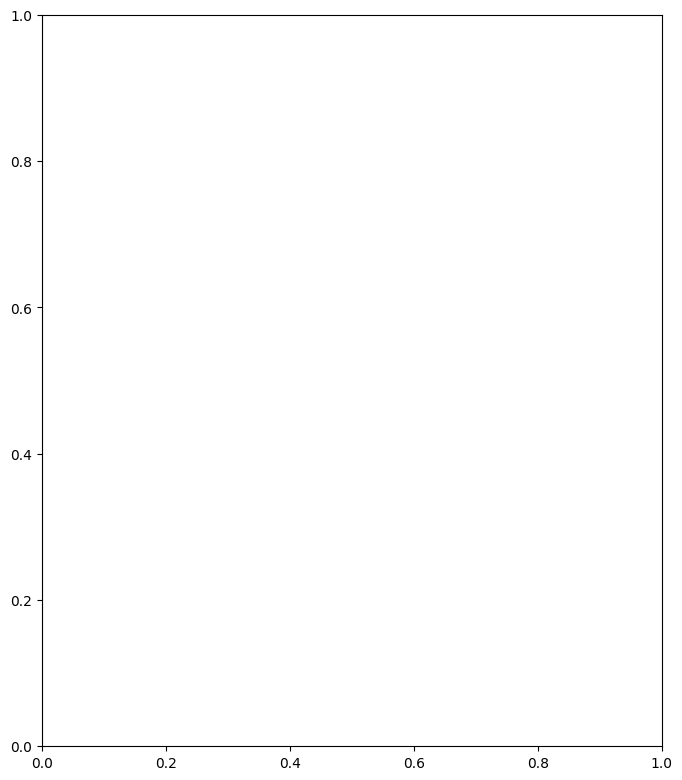

In [ ]:
from lightautoml.addons.tabular_interpretation import SSWARM
import shap
explainer = SSWARM(model)
explainer = train_data.sample(100)
shap_values = explainer.shap_values(explainer, n_jobs=4)
shap.summary_plot(shap_values[1], explainer[explainer.used_feats])

### Инференс фичей

In [ ]:
# загрузка теста и шаблона сэмпла
test_data = pd.read_excel(os.path.join(path_to_folder,'data','test.xlsx'),index_col=0)
sample = pd.read_csv(os.path.join(path_to_folder,'data','example.csv'),names = ['pred'])
# подготовка фичей
test_data = features_pack_v3(test_data)
# предикты и сохранение
sample['pred'] = np.around(model.predict(test_data).data.reshape(-1),3)#(model.predict(test_data).data.reshape(-1) >= thr).astype(int)
sample.to_csv(os.path.join(path_to_folder,'data',config_model['model_name'] + '_sample.csv'),header = False,index=False)
# проверка что все сохранилось
pd.read_csv(os.path.join(path_to_folder,'data',config_model['model_name'] + '_sample.csv'),names=['pred']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11218 entries, 0 to 11217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pred    11218 non-null  float64
dtypes: float64(1)
memory usage: 87.8 KB
